<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/25_Ultra_Lite_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Используя шаблон ноутбука, напишите загрузку данных и прогнозирование акций Лукойла на 1 шаг с помощью Dense и Conv1D сетей (две отдельные сети).

Можно подсматривать в исходный ноутбук с занятия, но желательно писать код своими руками.

#Прогнозирование акций Лукойл

In [ ]:
# Библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # отрисовка графиков

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model # Два варианта моделей  
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки

from sklearn.preprocessing import StandardScaler, MinMaxScaler # Нормировщики

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cчитываем данные
base_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/18_19.csv', sep=';')

In [ ]:
# Выводим первые 5 строк
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
# Выцепляем numpy значения .values
# Выводим нулевой элемент
txt = base_data.values[0]
print(txt)

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [ ]:
base_data16 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

data16_17.shape[0]

263925

In [ ]:
# Выводим параметры одного файла
d = data18_19
print(len(d)) # Сколько есть записей
print(len(d.iloc[0])) # Длина одной строки данных
print(d.iloc[0]) # Пример первой строки данных


217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
# объединяем базы из х файлов
data = data16_17.copy()
data = pd.concat([data16_17, data18_19]) # Присоединяем к копии первой базы вторую
data = np.array(data)

In [ ]:
#  Сравниваем размеры (проверка)
print(len(data16_17))
print(len(data18_19))
print(len(data))

263925
217947
481872


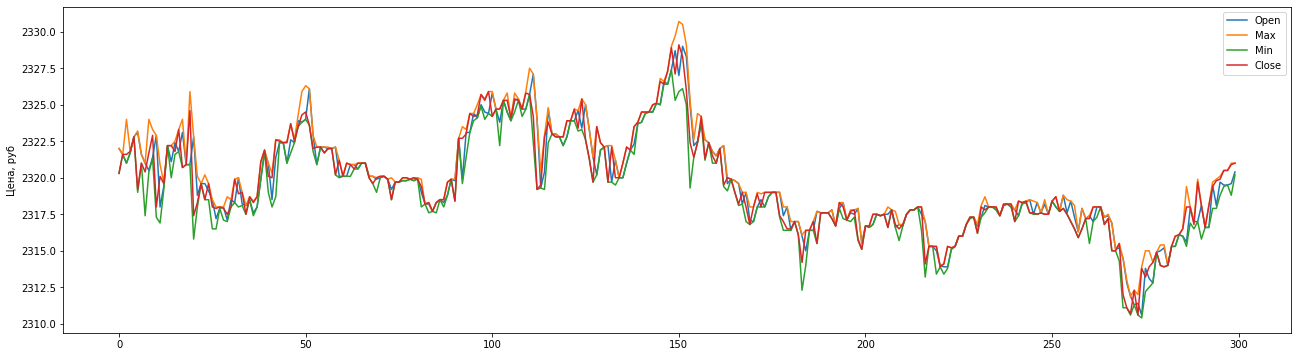

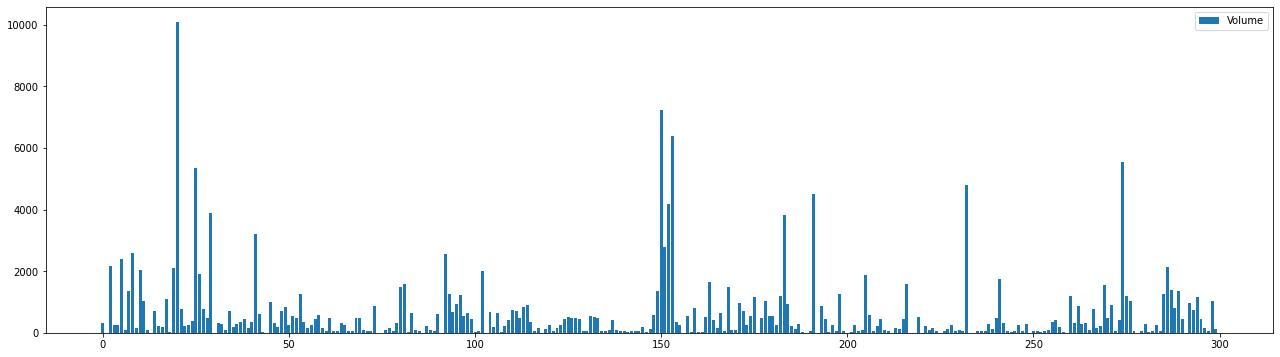

In [ ]:
# Отображаем исходные от точки start и длиной stop
start = 100 # С какой точки стартуем
# stop = data.shape[0] #сколько точек отрисуем
length = 300 #сколько точек отрисуем

# Заполняем текстовые названия каналов
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
# Четыре основных кнала - open, max, min, close
plt.figure(figsize=(22,6))
for i in range(4):
  # Отрисовываем часть данных
  # От начальной точки , до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+length, i],
           label = chanelNames[i])
plt.ylabel('Цена, руб')
plt.legend()
plt.show()

#Канал volume
plt.figure(figsize=(22, 6))
plt.bar(x=np.arange(length), height=data[start:start+length, 4], label = 'Volume')
plt.legend()
plt.show()

# Функция загрузки данных

In [ ]:
# Формируем параметры загрузки данных 

xLen = 300      #Анализируем по 300 прошедшим точкам
valLen = 30000  #Используем 30 000 заисей для проверки

trainLen = data.shape[0] - valLen # Размер обучающей выборки

# Делим данные на обучающую и тестовую выборки
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape, т.к. у нас только один столбец по одному значению
yTrain, yTest = np.reshape(data [:trainLen,3], (-1,1)), np.reshape(data[trainLen+xLen+2:,3], (-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)


#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20) 

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                                  length = xLen,
                                  stride = 1,
                                  batch_size = 20)


In [ ]:
print(trainDataGen[0][0].shape, 
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 1)


# Функции визуализации


In [ ]:
# Расчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдает результаты предсказания predVal
# и правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)

def getPred(currModel, xVal, yVal, yScaler):
  # предсказываем ответ сети на проверочной выборке
  # и возвращаем исходный масштаб данных до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)



# Функция визуализирует графики , что предсказала сеть и какие были правильные ответы
# start - точка , с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

  # Функция расчета корреляции двух одномерных векторов
def correlate(a, b):
    # Расчитываем основные показатели
    ma = a.mean() #среднее значение первого вектора
    mb = b.mean() #среднее значение второго вектора
    mab = (a*b).mean() #среднее значение произведения векторов
    sa = a.std() #среднеквадратичное отклонение первого вектора
    sb = b.std() #среднеквадратичное отклонение второго вектора

    # Расчитываем корреляцию
    val = 1
    if ((sa>0)&(sb>0)):
      val = (mab-ma*mb)/(sa*sb)
    return val

#Функция отрисовки корреляции прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать назад сигнал для расчета корреляции

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #проходим по всем каналам
  for ch in channels:
    corr = [] # создаем пустой лист, в нем будут корреляции при смещении на i шагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    # Постепенно увеличиваем шаг,на сколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # получаем сигнал, смещенный на i шагов назад
      #predVal[i:, ch]
      # сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i, ch]
      # рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i, ch], predVal[i:, 0]))

    own_corr = [] # создаем пустой лист, в нем будут корреляции при смещении а i шагов обратно

      # Постепенно увеличиваем шаг, на сколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # получаем сигнал, смещенный на i шагов назад
      # predVal[i:, ch]
      # сравниваем его с верными ответами , без смещения назад
      # yValUnscaled[:yLen-i, ch]
      # Рассчитываем корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i, ch], yValUnscaled[i:, ch]))

    # Отображаем график корреляций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
# Содадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                              length=300, sampling_rate=1,
                              batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []                            
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)


# Dense network

In [ ]:
# Создаем нейронку
model1D_2 = Sequential()
model1D_2.add(Flatten(input_shape = (xLen, 5)))
model1D_2.add(Dense(150, activation='relu'))
model1D_2.add(Dense(1, activation='linear'))

#Компилируем
model1D_2.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

model1D_2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 1500)              0         
                                                                 
 dense_8 (Dense)             (None, 150)               225150    
                                                                 
 dense_9 (Dense)             (None, 1)                 151       
                                                                 
Total params: 225,301
Trainable params: 225,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Запускаем обучение
history = model1D_2.fit(trainDataGen,
                        epochs=20,
                        verbose=1,
                        validation_data = testDataGen)

Epoch 1/20
22579/22579 [==============================] - 83s 4ms/step - loss: 0.0084 - val_loss: 1.0409e-04
Epoch 2/20
22579/22579 [==============================] - 83s 4ms/step - loss: 0.0019 - val_loss: 2.3535e-05
Epoch 3/20
22579/22579 [==============================] - 83s 4ms/step - loss: 2.3284e-04 - val_loss: 0.0020
Epoch 4/20
22579/22579 [==============================] - 82s 4ms/step - loss: 1.0961e-04 - val_loss: 1.8532e-05
Epoch 5/20
22579/22579 [==============================] - 81s 4ms/step - loss: 4.3676e-05 - val_loss: 2.0870e-05
Epoch 6/20
22579/22579 [==============================] - 83s 4ms/step - loss: 2.9278e-05 - val_loss: 1.0325e-04
Epoch 7/20
22579/22579 [==============================] - 81s 4ms/step - loss: 2.7696e-05 - val_loss: 1.2086e-05
Epoch 8/20
22579/22579 [==============================] - 82s 4ms/step - loss: 2.1374e-05 - val_loss: 6.0363e-05
Epoch 9/20
22579/22579 [==============================] - 79s 4ms/step - loss: 1.9963e-05 - val_loss: 1.9595

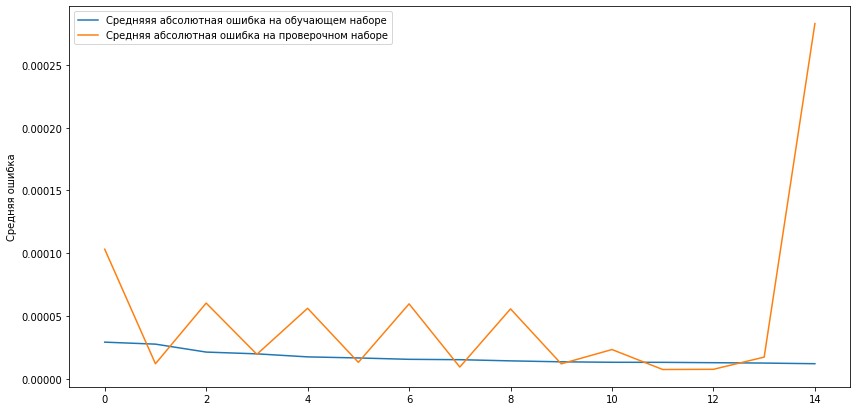

In [ ]:
#Выводим графики
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'][5:],
         label = 'Средняяя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][5:],
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:

#Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = getPred(model1D_2, xVal[0], yVal[0], yScaler) #Прогнозируем данные



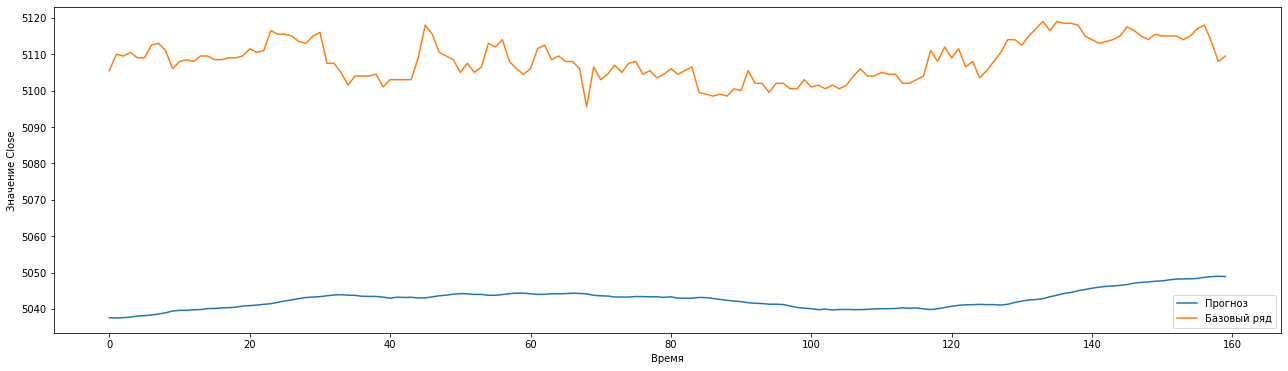

In [ ]:
# Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

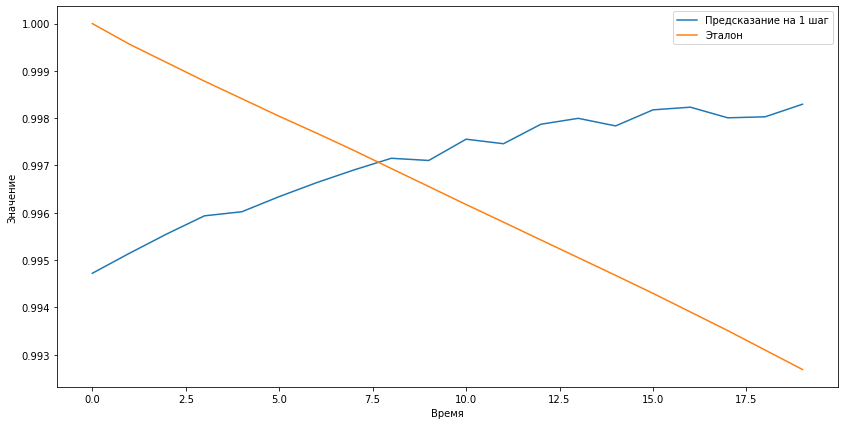

In [ ]:
#Отображаем корреляцию 
# Используем входной канал
# Проверяем корреляцию на глубину 60 шагов
showCorr([0], 20, predVal, yValUnscaled)

In [ ]:
model1D_2.compile(loss="mse", optimizer=Adam(lr=1e-5))
#Запускаем обучение
history = model1D_2.fit(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen)

Epoch 1/20
22579/22579 [==============================] - 84s 4ms/step - loss: 6.4803e-04 - val_loss: 2.2950e-04
Epoch 2/20
22579/22579 [==============================] - 82s 4ms/step - loss: 3.2395e-04 - val_loss: 0.0039
Epoch 3/20
22579/22579 [==============================] - 82s 4ms/step - loss: 3.2721e-04 - val_loss: 9.3537e-04
Epoch 4/20
22579/22579 [==============================] - 84s 4ms/step - loss: 4.1464e-04 - val_loss: 8.2554e-04
Epoch 5/20
22579/22579 [==============================] - 85s 4ms/step - loss: 3.5935e-04 - val_loss: 1.2637e-04
Epoch 6/20
22579/22579 [==============================] - 85s 4ms/step - loss: 3.6245e-04 - val_loss: 0.0124
Epoch 7/20
22579/22579 [==============================] - 83s 4ms/step - loss: 2.5316e-04 - val_loss: 4.3836e-04
Epoch 8/20
22579/22579 [==============================] - 82s 4ms/step - loss: 2.9268e-04 - val_loss: 7.4534e-06
Epoch 9/20
22579/22579 [==============================] - 82s 4ms/step - loss: 2.8930e-04 - val_loss: 7.

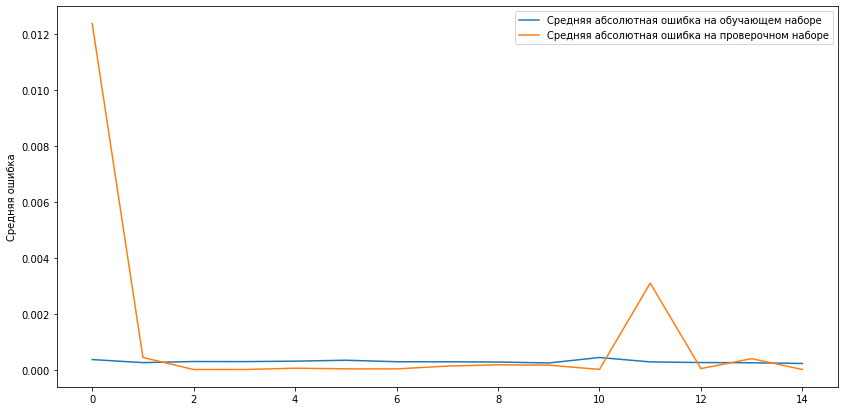

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][5:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][5:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

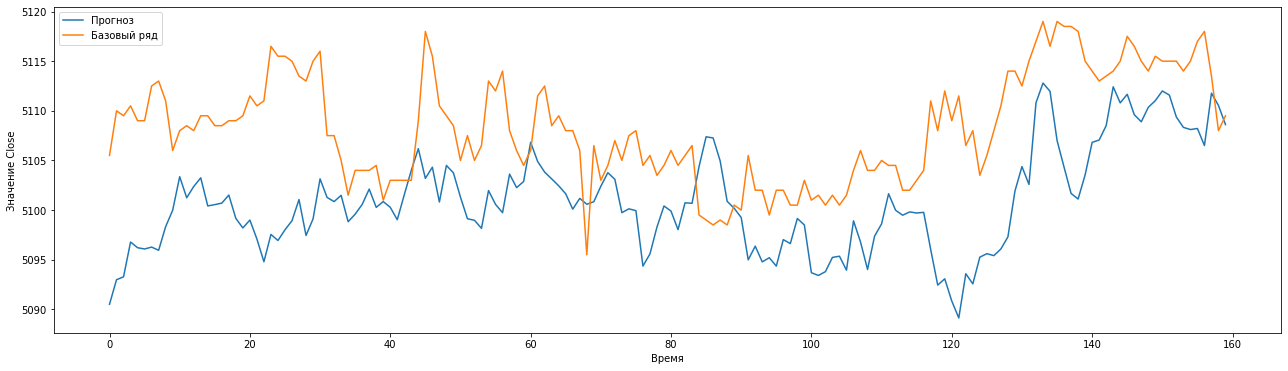

In [ ]:
#Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = getPred(model1D_2, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

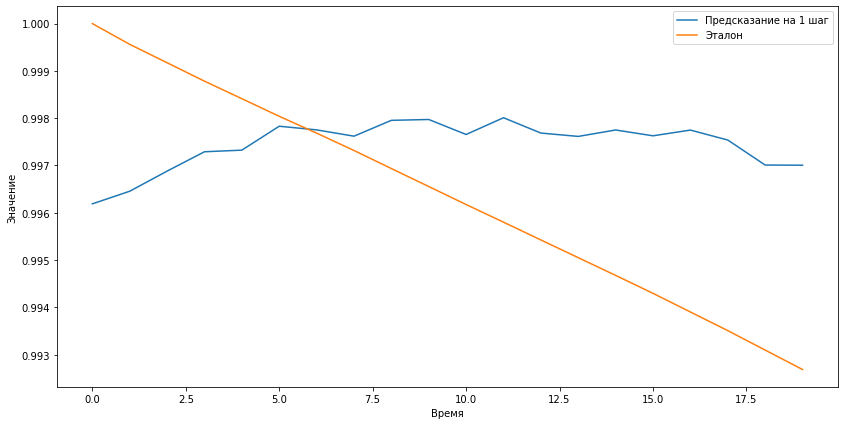

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 20, predVal, yValUnscaled)

# Conv1D

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(64, 5, input_shape = (xLen,5), activation="relu"))
modelC.add(Conv1D(64, 5, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(100, activation="relu"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 296, 64)           1664      
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 146, 64)          0         
 )                                                               
                                                                 
 flatten_5 (Flatten)         (None, 9344)              0         
                                                                 
 dense_10 (Dense)            (None, 100)               934500    
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                      

In [ ]:
history = modelC.fit(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/50
22579/22579 [==============================] - 903s 40ms/step - loss: 2.6310e-04 - val_loss: 9.6593e-05
Epoch 2/50
22579/22579 [==============================] - 907s 40ms/step - loss: 6.1287e-05 - val_loss: 2.2120e-04
Epoch 3/50
22579/22579 [==============================] - 919s 41ms/step - loss: 4.1347e-05 - val_loss: 2.0378e-05
Epoch 4/50
22579/22579 [==============================] - 919s 41ms/step - loss: 3.0945e-05 - val_loss: 1.7507e-05
Epoch 5/50
22579/22579 [==============================] - 921s 41ms/step - loss: 2.6041e-05 - val_loss: 3.2500e-04
Epoch 6/50
22579/22579 [==============================] - 917s 41ms/step - loss: 2.5248e-05 - val_loss: 1.9983e-05
Epoch 7/50
22579/22579 [==============================] - 920s 41ms/step - loss: 2.1485e-05 - val_loss: 1.1696e-05
Epoch 8/50
22579/22579 [==============================] - 916s 41ms/step - loss: 2.0129e-05 - val_loss: 2.0051e-05
Epoch 9/50
22579/22579 [==============================] - 914s 40ms/step - loss:

Переписала ноутбук , но не хватило ОЗУ на завершение обучения сетки Conv1D